## Import Libraries

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from shapeGMM import gmm_shapes
from shapeGMMTorch import torch_sgmm
from shapeGMMTorch import scripts
import MDAnalysis as md
import torch
import pickle

In [2]:
# Parameters
col_indx = 3  #! 3 is meta.bias, 4 is meta.rbias, -1 means use meta.fbias from colvar_reweight file
data_path = "../../../"
gro_file = "run_ala2_metad_sigma0.3_height1.2_pace500_bf10.gro"
traj_file = "run_ala2_metad_sigma0.3_height1.2_pace500_bf10_wrapped.trr"
colvar_file = "run_ala2_metad_sigma0.3_height1.2_pace500_bf10.colvars.dat"
out_dir = "./"

## Load MetaD Trajectory for ADP

In [3]:
backbone_selection_101 = "(name C and resid 1) or (name C CA N and resid 2) or (name N and resid 3)"

# load data
prmtopFileName =  data_path + gro_file
trajFiles = [data_path+traj_file]
print(trajFiles)
print(len(trajFiles))

coord = md.Universe(prmtopFileName,trajFiles)
sel_backbone_101 = coord.select_atoms(backbone_selection_101)
print("selected atom indices:", sel_backbone_101.indices)

print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:",coord.trajectory.n_frames)
print("Number of atoms being analyzed:",sel_backbone_101.n_atoms)
print("Number of frames being analyzed:",coord.trajectory.n_frames)

trajData = np.empty((coord.trajectory.n_frames,sel_backbone_101.n_atoms,3),dtype=float)
count = 0

for ts in coord.trajectory:
    trajData[count,:,:] = sel_backbone_101.positions - sel_backbone_101.center_of_geometry()
    count += 1

['../../../run_ala2_metad_sigma0.3_height1.2_pace500_bf10_wrapped.trr']
1
selected atom indices: [ 4  6  8 14 16]
Number of atoms in trajectory: 22
Number of frames in trajectory: 100001
Number of atoms being analyzed: 5
Number of frames being analyzed: 100001


## load phi-psi data and bias from metad sim

In [4]:
if col_indx != -1:
    time, phi, psi, bias = np.loadtxt(data_path+colvar_file, usecols=(0,1,2,col_indx), unpack=True)
else:
    # loads the final bias 
    time, phi, psi, bias = np.loadtxt(data_path+"colvar_reweight", usecols=(0,1,2,3), unpack=True)
    bias -= bias.min()

time *= 0.001  # in ns

## plot phi-psi

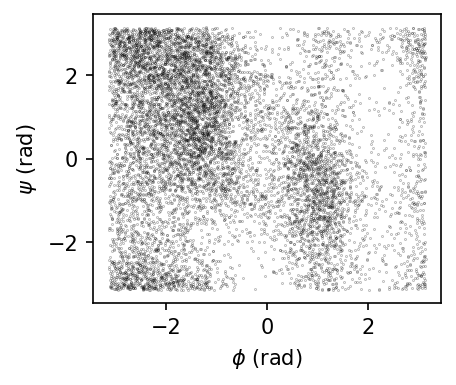

In [5]:
plt.figure(figsize=(3.0,2.5), dpi=150)
plt.xlabel("$\phi$ (rad)")
plt.ylabel("$\psi$ (rad)")
plt.scatter(phi[::10], psi[::10], marker=".", s=0.05, color='k', alpha=1.0)

## plot different choice of metad biases

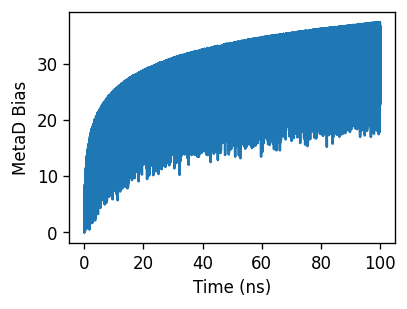

In [6]:
plt.figure(figsize=(3.5,2.5), dpi=120)
plt.xlabel("Time (ns)")
plt.ylabel("MetaD Bias")
plt.plot(time, bias)

## plot different weights for reweighting

In [7]:
kbt = 0.596161 # in kcal/mol @ 300K

# calculate biases
weights = np.exp(bias/kbt)
weights /= np.sum(weights)

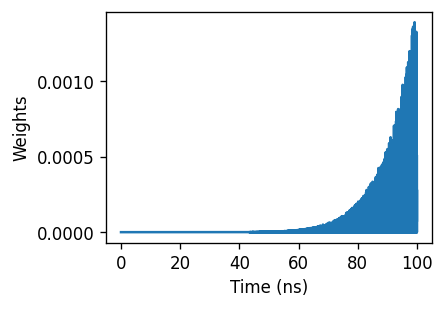

In [8]:
plt.figure(figsize=(3.5,2.5), dpi=120)
plt.xlabel("Time (ns)")
plt.ylabel("Weights")
plt.plot(time, weights)

## n_clusters = 2 

In [11]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 2, 40, weights, device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 100001
Number of clusters: 2
Number of attempts: 40
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              53.575          27.513
       2              53.956          33.380
       3              32.014          37.489
       4              53.938          33.309
       5              53.814          34.808
       6              54.936          35.685
       7              53.876          34.698
       8              43.601          32.893
       9              53.925          33.535
      10              57.230          22.773
      11              53.749          33.956
      12              54.936          22.872
      13              53.970          32.679
      14              53.948          34.489
      15              56.639           9.989
      16              57.229          22.673
      17              53.285          34.894
      18              56.596          28.223
      19       

In [12]:
with open("wsgmm_2state_nattempts_40.pickle", 'wb') as f:
    pickle.dump(wsgmm, f)

In [13]:
with open("wsgmm_2state_nattempts_40.pickle", "rb") as f:
    wsgmm2 = pickle.load(f)

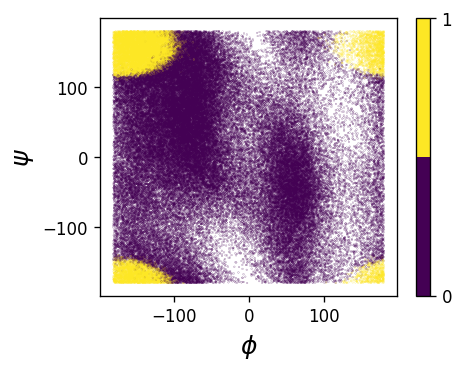

In [14]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm2.cluster_ids)
cmap = plt.get_cmap('viridis', len(color_values))
custom_cmap = ListedColormap(cmap(color_values))

# plot
plt.figure(figsize=(4,3), dpi=120)
plt.xlabel("$\phi$", fontsize=15)
plt.ylabel("$\psi$", fontsize=15)
plt.yticks([-100,0,100])
plt.scatter(phi*180/3.14, psi*180/3.14, c=wsgmm2.cluster_ids, marker=".", s=0.05, cmap=custom_cmap)
cbar = plt.colorbar(ticks=color_values)

## n_clusters = 3 

In [15]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 3, 40, weights, device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 100001
Number of clusters: 3
Number of attempts: 40
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              54.947          54.918
       2              53.406          95.464
       3              58.183          98.134
       4              57.602          57.512
       5              46.216          89.947
       6              58.180          93.217
       7              54.939          31.673
       8              57.603          79.196
       9              53.749          94.080
      10              57.603          67.180
      11              58.235          34.692
      12              53.982          84.414
      13              52.420          91.743
      14              57.985          58.699
      15              54.936          67.284
      16              58.172          94.286
      17              57.602          78.326
      18              58.176          97.826
      19       

In [16]:
with open("wsgmm_3state_nattempts_40.pickle", 'wb') as f:
    pickle.dump(wsgmm, f)

In [17]:
with open("wsgmm_3state_nattempts_40.pickle", "rb") as f:
    wsgmm3 = pickle.load(f)

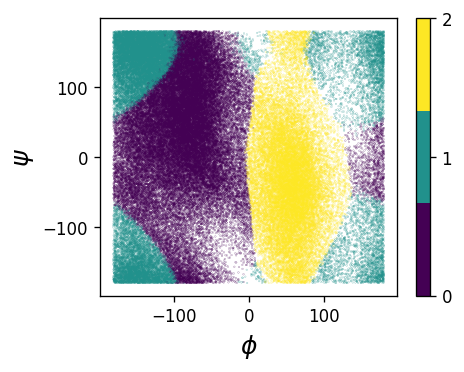

In [18]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm3.cluster_ids)
cmap = plt.get_cmap('viridis', len(color_values))
custom_cmap = ListedColormap(cmap(color_values))


# plot
plt.figure(figsize=(4,3), dpi=120)
plt.xlabel("$\phi$", fontsize=15)
plt.ylabel("$\psi$", fontsize=15)
plt.yticks([-100,0,100])
plt.scatter(phi*180/3.14, psi*180/3.14, c=wsgmm3.cluster_ids, marker=".", s=0.05, cmap=custom_cmap)
cbar = plt.colorbar(ticks=color_values)

## n_clusters =4 

In [19]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 4, 40, weights, device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 100001
Number of clusters: 4
Number of attempts: 40
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              53.961          52.583
       2              57.608          72.024
       3              58.925         123.823
       4              58.238          36.220
       5              53.996         107.962
       6              57.555         107.889
       7              53.646         107.086
       8              58.214          28.266
       9              58.203         109.842
      10              53.875         105.986
      11              57.998          65.100
      12              57.590          84.712
      13              58.333         128.462
      14              57.610          68.621
      15              55.616         111.745
      16              57.615          76.232
      17              58.752          52.303
      18              58.222          30.603
      19       

In [20]:
with open("wsgmm_4state_nattempts_40.pickle", "wb") as f:
    pickle.dump(wsgmm, f)

In [21]:
with open("wsgmm_4state_nattempts_40.pickle", "rb") as f:
    wsgmm4 = pickle.load(f)

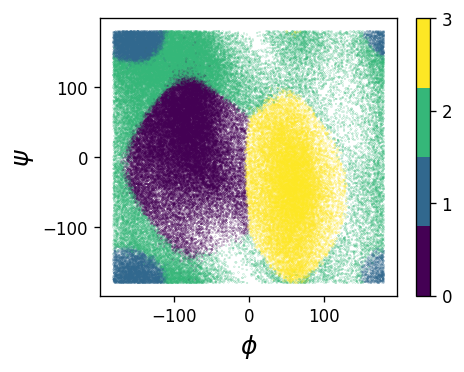

In [22]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm4.cluster_ids)
cmap = plt.get_cmap("viridis", len(color_values))
custom_cmap = ListedColormap(cmap(color_values))


# plot
plt.figure(figsize=(4,3), dpi=120)
plt.xlabel("$\phi$", fontsize=15)
plt.ylabel("$\psi$", fontsize=15)
plt.yticks([-100,0,100])
plt.scatter(phi*180/3.14, psi*180/3.14, c=wsgmm4.cluster_ids, marker=".", s=0.05, cmap=custom_cmap)
cbar=plt.colorbar(ticks=color_values)

## n_clusters = 5 -->

In [23]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 5, 40, weights, device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 100001
Number of clusters: 5
Number of attempts: 40
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              58.027         121.149
       2              59.269          43.672
       3              58.802          44.847
       4              57.605          74.637
       5              59.272          37.316
       6              58.555         123.227
       7              58.255          44.975
       8              58.970          28.931
       9              58.159         132.408
      10              57.554         125.643
      11              59.206         146.104
      12              58.603          30.035
      13              57.644          85.546
      14              57.613          48.065
      15              59.270          40.667
      16              58.518         121.285
      17              59.164         152.513
      18              58.958          54.635
      19       

In [24]:
with open("wsgmm_5state_nattempts_40.pickle", "wb") as f:
    pickle.dump(wsgmm, f)

In [25]:
with open("wsgmm_5state_nattempts_40.pickle", "rb") as f:
    wsgmm5 = pickle.load(f)

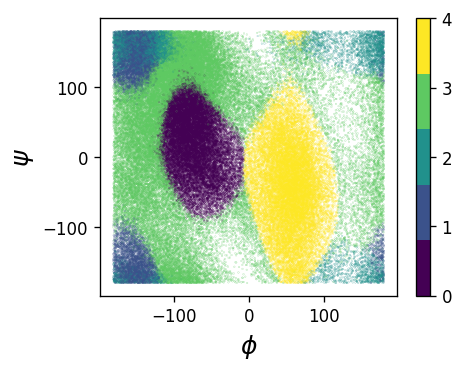

In [26]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm5.cluster_ids)
cmap = plt.get_cmap("viridis", len(color_values))
custom_cmap = ListedColormap(cmap(color_values))


# plot
plt.figure(figsize=(4,3), dpi=120)
plt.xlabel("$\phi$", fontsize=15)
plt.ylabel("$\psi$", fontsize=15)
plt.yticks([-100,0,100])
plt.scatter(phi*180/3.14, psi*180/3.14, c=wsgmm5.cluster_ids, marker=".", s=0.05, cmap=custom_cmap)
cbar=plt.colorbar(ticks=color_values)

## n_clusters = 6 -->

In [27]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 6, 40, weights, device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 100001
Number of clusters: 6
Number of attempts: 40
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              58.954          57.445
       2              59.221         147.755
       3              59.362          50.085
       4              58.854          66.654
       5              59.297         150.749
       6              58.428          45.527
       7              53.957         112.666
       8              59.458          59.221
       9              58.427          80.150
      10              58.967          43.739
      11              59.627          64.734
      12              58.879          66.254
      13              58.244          38.757
      14              58.434         105.194
      15              59.063          63.050
      16              60.083          56.218
      17              57.652         104.588
      18              59.540         168.797
      19       

In [28]:
with open("wsgmm_6state_nattempts_40.pickle", "wb") as f:
    pickle.dump(wsgmm, f)

In [29]:
with open("wsgmm_6state_nattempts_40.pickle", "rb") as f:
    wsgmm6 = pickle.load(f)

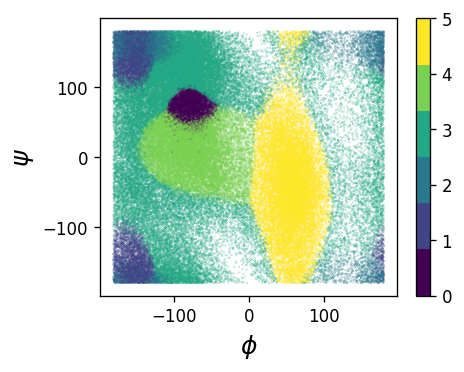

In [30]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm6.cluster_ids)
cmap = plt.get_cmap("viridis", len(color_values))
custom_cmap = ListedColormap(cmap(color_values))


# plot
plt.figure(figsize=(4,3), dpi=120)
plt.xlabel("$\phi$", fontsize=15)
plt.ylabel("$\psi$", fontsize=15)
plt.yticks([-100,0,100])
plt.scatter(phi*180/3.14, psi*180/3.14, c=wsgmm6.cluster_ids, marker=".", s=0.05, cmap=custom_cmap)
cbar=plt.colorbar(ticks=color_values)